Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Transfer_learning_TP.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FTransfer_learning_TP.ipynb&branch=main" target="_blank">Rosenblatt</a>


TP - Transfer Learning
======================

Ce notebook de travail est une simple copie du notebook `Transfer_learning_tutorial.ipynb` (sauf la dernière partie sur la visualisation qui a été supprimée).
Le but est de partir de ce notebook et de l'adapter pour répondre aux questions suivantes: 

__Question 1.__ On va chercher à mettre en évidence le bénéfice apporté par l'utilisation du réseau ResNet18 avec des poids pré-entrainé. Pour cela, refaire tourner les expériences en partant du réseau avec des poids aléatoires. Que constate-t-on ?

__Question 2.__ Refaire également l'expérience en remplaçant le réseau ResNet18 par un simple réseau convolutionnel à une ou deux couches permettant d'avoir la même dimension de sortie. Commenter les résultats.

__Question 3.__ A présent, refaire les expériences initiales du notebook, ainsi que celles des questions 1 et 2 en utilisant le dataset STL10 (disponible dans la librairie `torchvision`). Commenter.

In [4]:
%matplotlib inline

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [6]:
# dowload the data

!rm -rf hymenoptera_data*
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few test and training images so as to understand the data
augmentations.



val data:


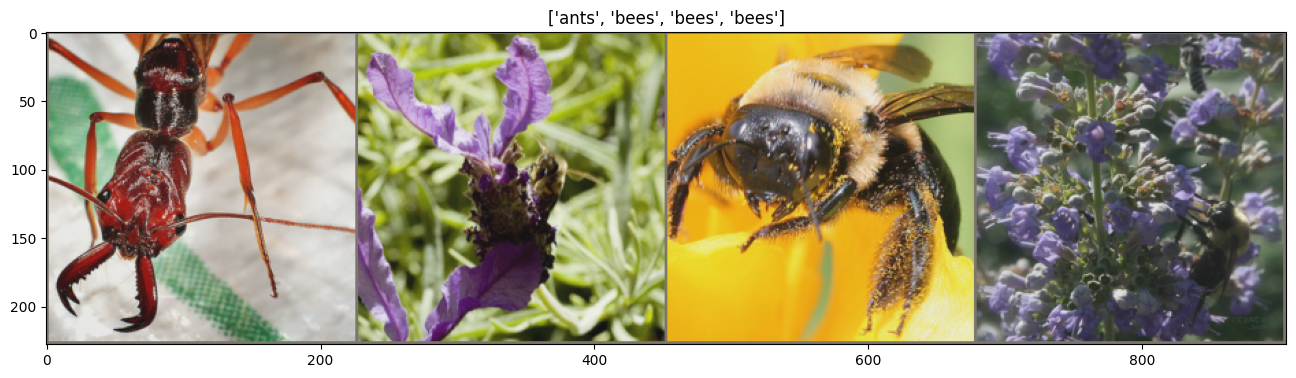

train data:


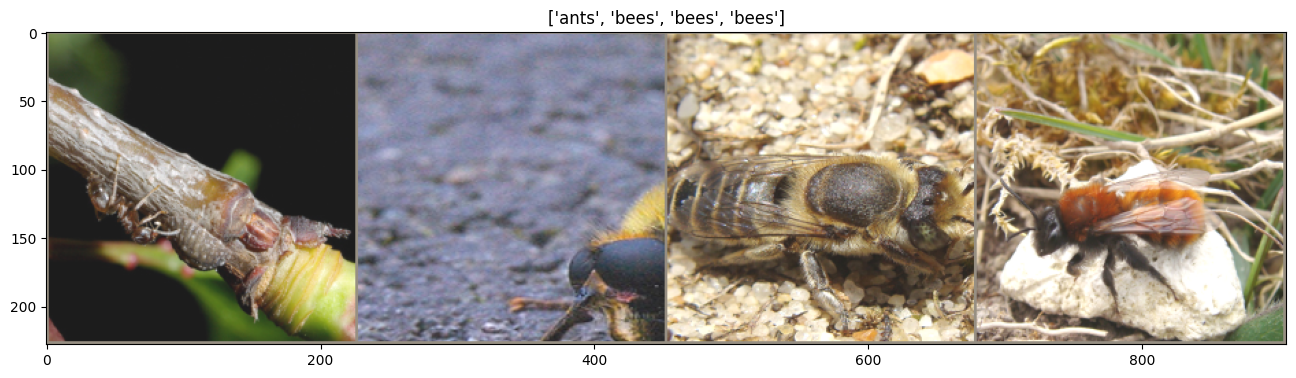

In [8]:
def imshow(inp, title=None, rescale=True):
    """Imshow for Tensor."""
    if len(inp.shape)==2:
      inp = np.tile(inp[None,:,:],(3,1,1))
    if rescale:
      inp = (inp - np.mean(inp)) / (4*np.std(inp)) + .5
    inp = inp.transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Display a row of teest data and a row of train data
for data_type in 'val', 'train':
  inputs, classes = next(iter(dataloaders[data_type]))
  inputs = torchvision.utils.make_grid(inputs)
  inputs = inputs.numpy() * np.array(normalize_std)[:,None,None] + np.array(normalize_mean)[:,None,None]
  print(data_type,'data:')
  plt.figure(figsize=(16,8))
  imshow(inputs, title=[class_names[x] for x in classes])
  plt.show()

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [10]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(16,8))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//4, 4, images_so_far)
                plt.axis('off')
                plt.title('predicted: {}'.format(class_names[preds[j]]))

                inp = inputs.cpu().data[j].numpy() * np.array(normalize_std)[:,None,None] + np.array(normalize_mean)[:,None,None]
                imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    plt.show()

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [17]:
model_ft = models.resnet18(weights='DEFAULT')

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8641 Acc: 0.4918
val Loss: 0.7488 Acc: 0.6209

Epoch 1/24
----------
train Loss: 0.7252 Acc: 0.5615
val Loss: 0.8417 Acc: 0.5752

Epoch 2/24
----------
train Loss: 0.8433 Acc: 0.5820
val Loss: 1.5445 Acc: 0.5425

Epoch 3/24
----------
train Loss: 0.7764 Acc: 0.5902
val Loss: 0.7904 Acc: 0.6667

Epoch 4/24
----------
train Loss: 0.7372 Acc: 0.6107
val Loss: 0.7060 Acc: 0.5556

Epoch 5/24
----------
train Loss: 0.6572 Acc: 0.6311
val Loss: 0.7677 Acc: 0.6275

Epoch 6/24
----------
train Loss: 0.7120 Acc: 0.6270
val Loss: 1.0641 Acc: 0.4706

Epoch 7/24
----------
train Loss: 0.6249 Acc: 0.6803
val Loss: 0.6913 Acc: 0.5882

Epoch 8/24
----------
train Loss: 0.5977 Acc: 0.6598
val Loss: 0.6275 Acc: 0.6928

Epoch 9/24
----------
train Loss: 0.5894 Acc: 0.6803
val Loss: 0.5965 Acc: 0.7124

Epoch 10/24
----------
train Loss: 0.5843 Acc: 0.6844
val Loss: 0.5944 Acc: 0.6732

Epoch 11/24
----------
train Loss: 0.5715 Acc: 0.7008
val Loss: 0.5924 Acc: 0.6928

Ep

In [19]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [21]:
model_conv = torchvision.models.resnet18(weights=None)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7712 Acc: 0.5041
val Loss: 0.6887 Acc: 0.5033

Epoch 1/24
----------
train Loss: 0.7349 Acc: 0.5246
val Loss: 0.6394 Acc: 0.6209

Epoch 2/24
----------
train Loss: 0.7885 Acc: 0.5205
val Loss: 0.7050 Acc: 0.5098

Epoch 3/24
----------
train Loss: 0.7778 Acc: 0.4959
val Loss: 0.6272 Acc: 0.6601

Epoch 4/24
----------
train Loss: 0.7589 Acc: 0.4836
val Loss: 0.6588 Acc: 0.6144

Epoch 5/24
----------
train Loss: 0.7267 Acc: 0.5328
val Loss: 1.0626 Acc: 0.4641

Epoch 6/24
----------
train Loss: 0.7071 Acc: 0.5861
val Loss: 0.6305 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.6649 Acc: 0.5738
val Loss: 0.6337 Acc: 0.6601

Epoch 8/24
----------
train Loss: 0.6625 Acc: 0.6066
val Loss: 0.6480 Acc: 0.6405

Epoch 9/24
----------
train Loss: 0.7080 Acc: 0.5451
val Loss: 0.6710 Acc: 0.5948

Epoch 10/24
----------
train Loss: 0.6601 Acc: 0.6148
val Loss: 0.6369 Acc: 0.6601

Epoch 11/24
----------
train Loss: 0.6684 Acc: 0.6148
val Loss: 0.6314 Acc: 0.6405

Ep

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



